In [1]:
import seaborn as sns
import math
import random
from copy import deepcopy
from collections import defaultdict
import gym
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

viridis = plt.get_cmap("viridis")
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
!pip install tensorboard

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=3, n_cols=3, n_win=3, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i,j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

Here we store the Q values for both players in a single dictionary since their states do not intersect.

In [ ]:
def evaluate_q(env, Q, player=1):
  done = False
  env.reset()
  while not done:
    # actions are simply all the empty spots 
    if env.curTurn == player:
      state, actions = env.getHash(), env.getEmptySpaces()
      best_action = actions[Q[state][tuple(actions.T)].argmax()]
      # reward 1 is given if crosses win and -1 in the opposite case
      observation, reward, done, _ = env.step(best_action)
    else:
      state, actions = env.getHash(), env.getEmptySpaces()
      best_action = actions[np.random.randint(0, len(actions))]
      observation, reward, done, _ = env.step(best_action)
  return reward * player


def choose_action(Q, state, actions, eps):
  if np.random.rand() > eps:
    action = actions[Q[state][tuple(actions.T)].argmax()]
  else:
    action = actions[np.random.randint(0, len(actions))]
  return action


def update_q_from_episode(env, Q, alpha, gamma, eps):
  env.reset()
  done = False
  sx, actions_x = env.getHash(), env.getEmptySpaces()
  ax = choose_action(Q, sx, actions_x, eps)
  observation, reward, done, _ = env.step(ax)
  s0, actions_0, _ = observation
  a0 = choose_action(Q, s0, actions_0, eps)
  while not done:
    if env.curTurn == 1: # crosses
      observation, reward, done, _ = env.step(ax)
      next_s0, actions_0, _ = observation
      if reward == 1: Q[sx][tuple(ax)] = 1  
      Q[s0][tuple(a0)] += alpha * (
          - reward + gamma * np.max(Q[next_s0]) - Q[s0][tuple(a0)]
          )
      if len(actions_0) > 0:
        next_a0 = choose_action(Q, next_s0, actions_0, eps)
        s0, a0 = next_s0, next_a0
    else:
      observation, reward, done, _ = env.step(a0)
      next_sx, actions_x, _ = observation
      if reward == -1: Q[s0][tuple(a0)] = 1
      Q[sx][tuple(ax)] += alpha * (reward 
                                   + gamma * np.max(Q[next_sx]) 
                                   - Q[sx][tuple(ax)])
      if len(actions_x) > 0:
        next_ax = choose_action(Q, next_sx, actions_x, eps)
        sx, ax = next_sx, next_ax


def train_q(env, nrows, ncols, alpha, gamma, eps, 
           num_iterations=100_000, eval_iters=1000, 
           eval_every_k_steps=10_000):
  Q = defaultdict(lambda: np.zeros((nrows, ncols)))
  rewards_x_all = []
  rewards_0_all = []
  iterations = []
  for i in tqdm(range(num_iterations)):
    update_q_from_episode(env, Q, alpha, gamma, eps)
    if (i + 1) % eval_every_k_steps == 0:
      rewards_x = np.mean(
          [evaluate_q(env, Q, player=1) for _ in range(eval_iters)])
      rewards_0 = np.mean(
          [evaluate_q(env, Q, player=-1) for _ in range(eval_iters)])
      rewards_x_all.append(rewards_x)
      rewards_0_all.append(rewards_0)
      iterations.append(i)
      print(f"Iteration:{i}, rewards_x = {rewards_x}, rewards_0 = {rewards_0}")

  return Q, rewards_x_all, rewards_0_all, iterations

In [ ]:
nrows, ncols, nwins = 3, 3, 3
env = TicTacToe(nrows, nwins, nwins)
Q, rewards_x_all, rewards_0_all, iterations = train_q(env, nrows, ncols, alpha=.05, gamma=1., eps=.1)

 10%|█         | 10168/100000 [00:20<36:03, 41.52it/s]

Iteration:9999, rewards_x = 0.8696, rewards_0 = 0.194


 20%|██        | 20262/100000 [00:41<25:32, 52.02it/s]

Iteration:19999, rewards_x = 0.8566, rewards_0 = 0.1814


 30%|███       | 30201/100000 [01:01<20:53, 55.68it/s]

Iteration:29999, rewards_x = 0.9478, rewards_0 = 0.3081


 40%|████      | 40238/100000 [01:21<19:09, 52.00it/s]

Iteration:39999, rewards_x = 0.7786, rewards_0 = 0.5477


 50%|█████     | 50171/100000 [01:42<18:59, 43.74it/s]

Iteration:49999, rewards_x = 0.8019, rewards_0 = 0.5518


 60%|██████    | 60179/100000 [02:00<11:05, 59.80it/s]

Iteration:59999, rewards_x = 0.9644, rewards_0 = 0.6439


 70%|███████   | 70195/100000 [02:20<10:53, 45.60it/s]

Iteration:69999, rewards_x = 0.9329, rewards_0 = 0.6735


 80%|████████  | 80172/100000 [02:39<05:53, 56.13it/s]

Iteration:79999, rewards_x = 0.9732, rewards_0 = 0.6271


 90%|█████████ | 90195/100000 [02:58<03:00, 54.31it/s]

Iteration:89999, rewards_x = 0.968, rewards_0 = 0.6714


100%|██████████| 100000/100000 [03:17<00:00, 507.19it/s]

Iteration:99999, rewards_x = 0.9849, rewards_0 = 0.7189


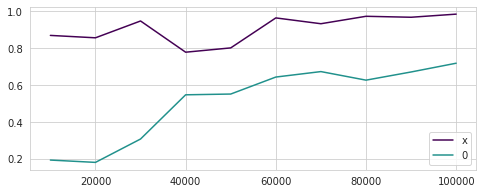

In [ ]:
fg, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(iterations, rewards_x_all, color=viridis(0), label="x")
ax.plot(iterations, rewards_0_all, color=viridis(0.5), label="0")
ax.legend(loc="best")
ax.set_title("Mean rewards during training")
fg.show()

###2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [ ]:
nrows, ncols, nwins = 4, 4, 4
env = TicTacToe(nrows, nwins, nwins)
Q, rewards_x_all, rewards_0_all, iterations = train_q(env, nrows, ncols, 
                                                      alpha=.05, gamma=0.98, eps=.4,
                                                      num_iterations=1_000_000, eval_every_k_steps=50_000)

  5%|▌         | 50096/1000000 [01:37<2:52:00, 92.04it/s]

Iteration:49999, rewards_x = 0.623, rewards_0 = 0.336


 10%|█         | 100072/1000000 [03:13<2:43:17, 91.85it/s]

Iteration:99999, rewards_x = 0.643, rewards_0 = 0.321


 15%|█▌        | 150074/1000000 [04:47<2:33:53, 92.04it/s]

Iteration:149999, rewards_x = 0.69, rewards_0 = 0.361


 20%|██        | 200086/1000000 [06:21<2:24:09, 92.48it/s]

Iteration:199999, rewards_x = 0.783, rewards_0 = 0.255


 25%|██▌       | 250110/1000000 [07:54<2:13:11, 93.83it/s]

Iteration:249999, rewards_x = 0.718, rewards_0 = 0.359


 30%|███       | 300089/1000000 [09:27<1:59:22, 97.72it/s]

Iteration:299999, rewards_x = 0.732, rewards_0 = 0.317


 35%|███▌      | 350077/1000000 [11:00<1:48:50, 99.52it/s]

Iteration:349999, rewards_x = 0.734, rewards_0 = 0.317


 40%|████      | 400089/1000000 [12:32<1:43:13, 96.86it/s]

Iteration:399999, rewards_x = 0.772, rewards_0 = 0.352


 45%|████▌     | 450067/1000000 [14:03<1:37:48, 93.71it/s]

Iteration:449999, rewards_x = 0.72, rewards_0 = 0.38


 50%|█████     | 500105/1000000 [15:35<1:26:33, 96.26it/s]

Iteration:499999, rewards_x = 0.819, rewards_0 = 0.397


 55%|█████▌    | 550070/1000000 [17:07<1:13:47, 101.63it/s]

Iteration:549999, rewards_x = 0.786, rewards_0 = 0.383


 60%|██████    | 600053/1000000 [18:37<1:29:27, 74.52it/s]

Iteration:599999, rewards_x = 0.783, rewards_0 = 0.444


 65%|██████▌   | 650076/1000000 [20:08<1:01:58, 94.11it/s]

Iteration:649999, rewards_x = 0.783, rewards_0 = 0.43


 70%|███████   | 700088/1000000 [21:39<51:08, 97.74it/s]  

Iteration:699999, rewards_x = 0.83, rewards_0 = 0.392


 75%|███████▌  | 750092/1000000 [23:11<43:28, 95.80it/s]

Iteration:749999, rewards_x = 0.804, rewards_0 = 0.394


 80%|████████  | 800080/1000000 [24:41<32:02, 104.01it/s]

Iteration:799999, rewards_x = 0.818, rewards_0 = 0.407


 85%|████████▌ | 850101/1000000 [26:12<25:11, 99.20it/s]

Iteration:849999, rewards_x = 0.833, rewards_0 = 0.41


 90%|█████████ | 900101/1000000 [27:42<15:58, 104.19it/s]

Iteration:899999, rewards_x = 0.816, rewards_0 = 0.459


 95%|█████████▌| 950108/1000000 [29:12<08:45, 94.98it/s]

Iteration:949999, rewards_x = 0.804, rewards_0 = 0.392


100%|██████████| 1000000/1000000 [30:42<00:00, 542.65it/s]

Iteration:999999, rewards_x = 0.844, rewards_0 = 0.454


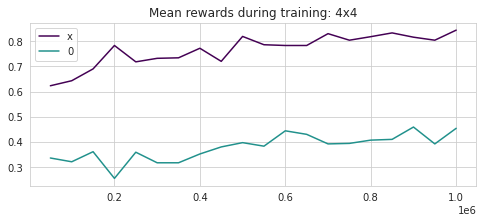

In [ ]:
fg, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(iterations, rewards_x_all, color=viridis(0), label="x")
ax.plot(iterations, rewards_0_all, color=viridis(0.5), label="0")
ax.legend(loc="best")
ax.set_title("Mean rewards during training: 4x4")
fg.show()

### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов.

### 4. Реализуйте Double DQN и/или Dueling DQN.

I start directly with a double DQN and introduce a model and a target model. The model will be trained, while the target model will be updated every predefined number of steps.

The state of the board will be a 3 x nrows x ncols tensor, where the first "channel" corresponds to positions of X, the second to positions of 0 and the last one indicates the empty spots. So it is similar to one-hot encoding. Now it is natural to apply convolutional layers and grow a number of channels.

In [4]:
from collections import deque
from copy import deepcopy
LOG_DIR = "logs"
GAMMA = 0.8
INITIAL_STEPS = 10
EPISODES = 30_000
EVAL_STEPS = 500
STEPS_PER_UPDATE = 5
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 50
BATCH_SIZE = 512
LEARNING_RATE = 5e-4
ALPHA = .99
MAX_EPS = .7
MIN_EPS = .01
EPS_DECAY = 10_000
BUFFER_SIZE = 25_000

class DQN:
  def __init__(self, 
               nrows, 
               ncols, 
               nwins, 
               model, 
               episodes=EPISODES,
               gamma=GAMMA,
               buffer_size=BUFFER_SIZE,
               batch_size=BATCH_SIZE,
               eval_steps=EVAL_STEPS,
               eval_episodes=1000,
               lr=LEARNING_RATE,
               alpha=ALPHA,
               max_eps=MAX_EPS,
               min_eps=MIN_EPS,
               steps_per_update=STEPS_PER_UPDATE,
               steps_per_target_update=STEPS_PER_TARGET_UPDATE,
               eps_decay=EPS_DECAY,
               log_dir=LOG_DIR):
    self.env = TicTacToe(nrows, ncols, nwins)
    self.nrows = nrows
    self.ncols = ncols
    self.steps = 0
    self.players = [-1, 1]
    self.episodes = episodes
    self.gamma = gamma
    self.batch_size = batch_size
    self.eval_steps = eval_steps
    self.eval_episodes = eval_episodes
    self.lr = lr
    self.alpha = alpha
    self.max_eps = max_eps
    self.min_eps = min_eps
    self.eps_decay = eps_decay
    self.steps_per_update = steps_per_update
    self.steps_per_target_update = steps_per_target_update
    self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    self.models = {player : deepcopy(model).to(self.device) \
                   for player in self.players}
    self.target_models = {player : deepcopy(self.models[player]).to(self.device) \
                          for player in self.players}
    self.buffers = {player : deque(maxlen=buffer_size) \
                    for player in self.players}

    self.optimizers = {player : 
                       torch.optim.RMSprop(self.models[player].parameters(),
                                             lr=self.lr, alpha=self.alpha) \
                       for player in self.players}

    self.writer = SummaryWriter(log_dir)

  def to_state(self, board):
    return np.array([board == player for player in [1, -1, 0]], dtype=int)

  def consume_transition(self, transition, player):
    self.buffers[player].append(transition)

  def sample_batch(self, player):
    samples = random.sample(self.buffers[player], self.batch_size)
    return samples

  def update_target_network(self, player):
    self.target_models[player].load_state_dict(
        self.models[player].state_dict())

  def act(self, state, player: int):
    state = torch.tensor(state).float().unsqueeze(0).to(self.device)
    self.models[player].eval()
    with torch.no_grad():
      # [batch, nrows * ncols]
      actions = self.models[player](state)
    return actions.cpu().argmax().item()

  def train_step(self, batch, player):
    states, actions, next_states, rewards, dones = \
            [torch.tensor(group).to(self.device) for group in zip(*batch)]
    states, next_states = states.float(), next_states.float()
    # [batch size]
    actions = actions.to(torch.int64)
    dones = dones.to(torch.int16)
    
    self.models[player].train()
    current_q = self.models[player](states).gather(dim=-1, index=actions.unsqueeze(1))
    target_q = rewards + \
                self.gamma * self.target_models[player](next_states).detach().max(-1)[0] * \
                (1 - dones)
    loss = F.smooth_l1_loss(current_q.squeeze(1), target_q.float())
    self.optimizers[player].zero_grad()
    loss.backward()
    self.writer.add_scalar(f"{player}'s loss", loss, self.steps)
    self.optimizers[player].step()

  def update(self, transition, player, learning=True):
    self.consume_transition(transition, player)
    if learning:
      if self.steps % self.steps_per_update == 0:
          if len(self.buffers[player]) < self.batch_size:
            return
          batch = self.sample_batch(player)
          self.train_step(batch, player)

      if self.steps % self.steps_per_target_update == 0:
        self.update_target_network(player)
      
      if player == -1:
        self.steps += 1

  def evaluate(self, player, episodes):
    self.models[player].eval()
    rewards = []
    for _ in range(episodes):
      self.env.reset()
      done = False
      while not done:
        if self.env.curTurn == player:
          best_action = self.env.action_from_int(
              self.act(self.to_state(self.env.board), 
                       player)
              )
        else:
          best_action = self.env.getEmptySpaces()[np.random.choice(
              len(self.env.getEmptySpaces()))]
        observation, reward, done, _ = self.env.step(best_action)

      if reward != -10:
        rewards.append(reward * player)
      else:
        if self.env.curTurn == player:
          rewards.append(reward)
  
    return np.sum(np.array(rewards) == 1) / episodes

  
  def train(self):
    # for evaluation
    rewards = defaultdict(list)
    max_reward = {1 : float("-inf"), -1 : float("-inf")}

    # we can also add some initial steps without updating the network with learning=False
    # but I didn't find it useful in this case so ommited the initial steps parameters
    learning = True
    for i in range(self.episodes):
      states = {}
      actions = {}
      done = False
      self.env.reset()
      while not done:
        player = self.env.curTurn
        states[player] = self.to_state(self.env.board)
        eps = self.min_eps + (self.max_eps - self.min_eps) * np.exp(- i / self.eps_decay)
        self.writer.add_scalar("Epsilon", eps, i)
        if random.random() < eps:
          actions[player] = np.random.randint(self.nrows * self.ncols)
        else:
          actions[player] = self.act(states[player], player)
        observation, reward, done, _ = self.env.step(
            self.env.action_from_int(actions[player])
            )
        if reward == -10:
          self.update((states[player], actions[player], self.to_state(self.env.board), reward, done), 
                      player,
                      learning=learning) 
        if reward == player: # the player who made a step won
          transition = (states[player], 
                        actions[player], 
                        self.to_state(self.env.board), 
                        1, 
                        done)
          self.update(transition, player, learning=learning)
        if -player in states:
          transition = (states[-player], 
                          actions[-player], 
                          self.to_state(self.env.board), 
                          reward * self.env.curTurn, 
                          done)
          self.update(transition, -player, learning=learning)
  

      if (i + 1) % self.eval_steps == 0:
          for player in self.players:
            reward = self.evaluate(player, self.eval_episodes)
            rewards[player].append([reward, i])
            if reward > max_reward[player]:
              max_reward[player] = reward
              torch.save(
                  self.models[player], 
                  f"model{self.nrows}x{self.ncols}player{'x' if player == 1 else '0'}.pkl")
        
          self.writer.add_scalar("X win ratio", rewards[1][-1][0], i)
          self.writer.add_scalar("0 win ratio", rewards[-1][-1][0], i)
    self.writer.close()
    return rewards

Tried to train each model on GPU for a few hours, so only did for 3x3 and 4x4. Unfortunately, tensorboard training curves can't be loaded.

### 3x3 with DQN

In [ ]:
SEED = 86
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = nn.Sequential(
            nn.Conv2d(3, 256, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 9)
        )

dqn = DQN(3, 3, 3, model)
rewards3x3 = dqn.train()

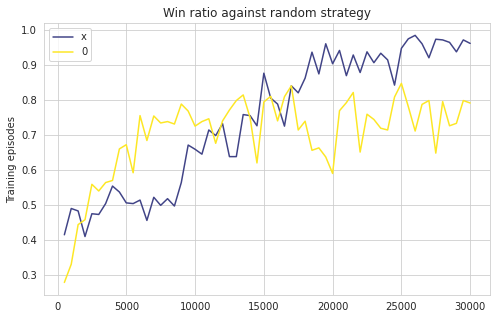

In [ ]:
fg, ax = plt.subplots(1, 1, figsize=(8, 5))

for i, player in enumerate([1, -1]): 
  rewards, episodes = zip(*rewards3x3[player])
  ax.plot(episodes, rewards, label=f"{'x' if player == 1 else '0'}", color=viridis(i + .2))
ax.legend(loc="best")
ax.set_title("Win ratio against random strategy")
ax.ylabel("Training episodes")

fg.show()

"Training episodes" label should be on the x-axis...

### 4x4 with double DQN

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 256, 2),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 16)
        )

dqn = DQN(4, 4, 4, model, 
          episodes=100_000, 
          eval_steps=1000,
          buffer_size=60_000, 
          gamma=.85, 
          max_eps=.9,
          min_eps=.05,
          lr=3e-4,
          steps_per_update=10,
          steps_per_target_update=250,
          )
rewards4x4 = dqn.train()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=logs

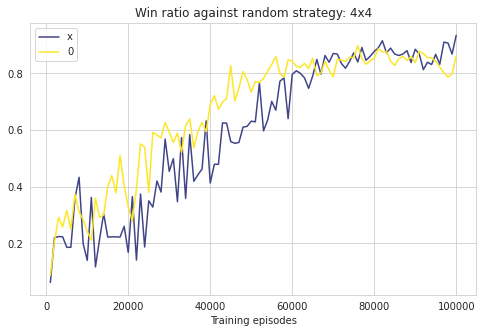

In [ ]:
fg, ax = plt.subplots(1, 1, figsize=(8, 5))

for i, player in enumerate([1, -1]): 
  rewards, episodes = zip(*rewards4x4[player])
  ax.plot(episodes, rewards, label=f"{'x' if player == 1 else '0'}", color=viridis(i + .2))
ax.legend(loc="best")
ax.set_title("Win ratio against random strategy: 4x4")
ax.set_xlabel("Training episodes")

fg.show()

Interestingly, the winning rate is the same when playing against a random strategy both for x and 0.

## Часть третья: расширим и углубим поиск

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [5]:
def to_torch_state(board):
    return torch.tensor(
        np.array([board == player for player in [1, -1, 0]])).float().unsqueeze(0)

def run_rollouts(env, action, pi_x=None, pi_0=None, num_rollouts=10):
  rewards = []
  policies = {1 : pi_x, -1 : pi_0}
  for _ in range(num_rollouts):
    env_clone = deepcopy(env)
    observation, reward, done, _ = env_clone.step(action)
    while not done:
      if policies[env_clone.curTurn] is not None:
        state = to_torch_state(env_clone.board).to(DEVICE)
        best_action = env_clone.action_from_int(
            policies[env_clone.curTurn](state).cpu().argmax().item())
      else:
        empty_spaces = env_clone.getEmptySpaces()
        best_action = empty_spaces[np.random.choice(len(empty_spaces))]
  
      observation, reward, done, _ = env_clone.step(best_action)
    rewards.append(reward)

  return np.array(rewards)

In [6]:
def play_with_rollouts(env, pi_x=None, pi_0=None, num_rollouts=50):
  '''Rollouts are only made for the player with a non None policy.
     In this case we test a policy with rollouts against a random strategy
  '''
  env.reset()
  policies = {1 : pi_x, -1 : pi_0}
  done = False
  while not done:
    empty_spaces = env.getEmptySpaces()
    best_action = empty_spaces[np.random.choice(len(empty_spaces))]
    max_reward = - 10
    if policies[env.curTurn] is not None:
      for action in empty_spaces:
        rewards = run_rollouts(env, 
                              action, 
                              pi_x=policies[1],
                              pi_0=policies[-1],
                              num_rollouts=num_rollouts)
        rewards = np.where(rewards != -10, 
                           rewards * env.curTurn, 
                           rewards)
        mean_reward = np.mean(rewards)
        if mean_reward > max_reward:
          max_reward = mean_reward
          best_action = action
    else:
      best_action = empty_spaces[np.random.choice(len(empty_spaces))]  
    observation, reward, done, _ = env.step(best_action)  
  return reward

Let's take a model from the previous task, but train it on a little number of episodes. Then we will add rollouts and see if it helps.

In [7]:
model = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 256, 2),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 16)
        )

dqn = DQN(4, 4, 4, model, 
          episodes=10_000, 
          eval_steps=1000,
          buffer_size=10_000, 
          gamma=.85, 
          max_eps=.9,
          min_eps=.05,
          lr=3e-4,
          steps_per_update=10,
          steps_per_target_update=250,
          )
rewards4x4 = dqn.train()

In [8]:
pi_x = torch.load("/content/model4x4playerx.pkl")
pi_0 = torch.load("/content/model4x4player0.pkl")

In [9]:
def evaluate(env, pi_x=None, pi_0=None):
  policies = {1 : pi_x, -1 : pi_0}
  env.reset()
  done = False
  while not done:
    if policies[env.curTurn] is not None:
      state = to_torch_state(env.board).to(DEVICE)
      best_action = env.action_from_int(
          policies[env.curTurn](state).cpu().argmax().item())
    else:
      empty_spaces = env.getEmptySpaces()
      best_action = empty_spaces[np.random.choice(len(empty_spaces))]

    observation, reward, done, _ = env.step(best_action)
  return reward

First, let's see how the policies for X and 0 perform. Note that we invert the reward for 0s.

In [ ]:
env = TicTacToe(4, 4, 4)
rewards_x = [evaluate(env, pi_x=pi_x) for _ in range(1000)]
rewards_0 = [evaluate(env, pi_0=pi_0) for _ in range(1000)]

print(f"X mean reward: {np.mean(rewards_x)}, 0 mean reward: {-np.mean(rewards_0)}")

X mean reward: -0.539, 0 mean reward: 0.079


In [10]:
env = TicTacToe(4, 4, 4)
rewards_x = [evaluate(env, pi_x=pi_x) for _ in range(1000)]
rewards_0 = [evaluate(env, pi_0=pi_0) for _ in range(1000)]

print(f"X mean reward: {np.mean(rewards_x)}, 0 mean reward: {-np.mean(rewards_0)}")

X mean reward: 0.063, 0 mean reward: 0.084


The results are quite poor. Let's add rollouts:

In [ ]:
env = TicTacToe(4, 4, 4)
rewards_rollouts_x = [play_with_rollouts(env, pi_x=pi_x, num_rollouts=10) for _ in range(1000)]

In [ ]:
rewards_rollouts_0 = [play_with_rollouts(env, pi_0=pi_0, num_rollouts=5) for _ in tqdm(range(1000))]

100%|██████████| 1000/1000 [21:36<00:00,  1.30s/it]


In [ ]:
print(f"X mean reward: {np.mean(rewards_rollouts_x)}, 0 mean reward: {- np.mean(rewards_rollouts_0)}")

X mean reward: 0.862, 0 mean reward: 0.732


With that many rollouts the performance is outstanding but with even a few looks good as well.

In [11]:
rewards_rollouts_x2 = [play_with_rollouts(env, pi_x=pi_x, num_rollouts=2) for _ in tqdm(range(1000))]

100%|██████████| 1000/1000 [10:30<00:00,  1.59it/s]


In [14]:
rewards_rollouts_02 = [play_with_rollouts(env, pi_0=pi_0, num_rollouts=2) for _ in tqdm(range(1000))]

100%|██████████| 1000/1000 [08:51<00:00,  1.88it/s]


In [16]:
print(f"X mean reward: {np.mean(rewards_rollouts_x2)}, 0 mean reward: {- np.mean(rewards_rollouts_02)}")

X mean reward: 0.724, 0 mean reward: 0.568


### 6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [ ]:
class Node:
  def __init__(self, env, action=None, parent=None, ucb_constant=np.sqrt(2)):
    self.parent = parent
    self.child_actions = {}
    self.action = action
    self.board = env.board
    self.turn = env.curTurn
    self.empty_spaces = env.getEmptySpaces()
    self.wins = 0
    self.num_visits = 0
    self.ucb_constant = ucb_constant

  @property
  def visited(self):
    return self.num_visits != 0
    
  @property
  def value(self):
    if self.num_visits != 0:
      return self.wins / self.num_visits
    else:
      return 0
  
  def _ucb_correction(self):
    if self.num_visits != 0:
      return self.ucb_constant * \
             np.sqrt(np.log(self.parent.num_visits) / self.num_visits)
    else:
      raise ValueError("UCB correction should not be calculatd on unvisited node")


  def get_best_action(self):
    '''Action to choose during selection stage'''
    best_value = 0
    for action in self.empty_spaces:
      value = self.child_actions[tuple(action)].value + \
              self.child_actions[tuple(action)]._ucb_correction()
      if value > best_value:
        best_value = value
        next_action = action
    return next_action


  def get_max_child(self):
    '''Action to choose during playing'''
    best_value = float("-inf")
    for action in self.child_actions:      
      value = self.child_actions[tuple(action)].value
      if value > best_value:
        best_value = value
        next_action = action
    return next_action


  def get_unused_action(self):
    next_action = None
    if len(self.child_actions) < len(self.empty_spaces):
      for action in self.empty_spaces:
        if tuple(action) not in self.child_actions:
          next_action = action
          break
    return next_action


class MCTS:
  def __init__(self, env, player, ucb_constant=np.sqrt(2)):
    self.env = env
    self.env.reset()
    self.root = Node(self.env)
    self.ucb_constant = ucb_constant
    self.player = player

  def rollout(self):
    done = False
    while not done:
      empty_spaces = self.env.getEmptySpaces()
      action = random.choice(empty_spaces)
      observation, reward, done, _ = self.env.step(action)
    return reward
    
  def play_game(self):
      self.env.reset()
      node = self.root
      done = False
      while not done:
        empty_spaces = self.env.getEmptySpaces()
        if self.env.curTurn == self.player:
          if len(node.child_actions) < len(empty_spaces):
            return self.rollout()
          next_action = node.get_max_child()
        else:
          next_action = random.choice(empty_spaces)
        observation, reward, done, _ = self.env.step(next_action)
        if done: return reward
        if tuple(next_action) not in node.child_actions:
          return self.rollout()
        else:
          node = node.child_actions[tuple(next_action)]
      return reward

  def backprop(self, node, reward):
    while node:
      node.num_visits += 1
      # say if player=1 and reward=1, then this player would want 
      # to choose a node which brings them to the win
      # and the turn of the chosen node will be -1 
      if node.turn == - reward:
        node.wins += 1
      node = node.parent


  def update(self):
    done = False
    self.env.reset()
    node = self.root
    while not done:
      # Selection
      if node.visited:
        if self.env.curTurn == self.player:
          next_action = node.get_unused_action() 
          if next_action is None:
            next_action = node.get_best_action()
        else:
          next_action = random.choice(self.env.getEmptySpaces())
      else:
        reward = self.rollout()
        break
      # Expansion
      observation, reward, done, _ = self.env.step(next_action)
      if tuple(next_action) in node.child_actions:
        node = node.child_actions[tuple(next_action)]
      else:
        new_node = Node(self.env, 
                        action=next_action, 
                        parent=node, 
                        ucb_constant=self.ucb_constant)
        node.child_actions[tuple(next_action)] = new_node
        node = new_node

    self.backprop(node, reward)    

In [ ]:
SEED = 86
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
env = TicTacToe(3, 3, 3)
rewards_mcts = {1 : [], -1 : []}
for player in rewards_mcts:
  tree = MCTS(env, player=player)
  for i in tqdm(range(80000)):
    tree.update()
    if (i + 1) % 1000 == 0:
      rewards_ = []
      for _ in range(1000):
        rewards_.append(tree.play_game())
      m = np.mean(rewards_)
      rewards_mcts[player].append(m)

100%|██████████| 80000/80000 [01:32<00:00, 868.95it/s] 


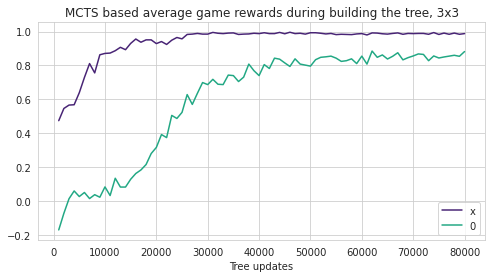

In [ ]:
fg, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot([1000 * i for i in range(1, len(rewards_mcts[1]) + 1)], 
        rewards_mcts[1], 
        label="x",
        color=viridis(0.1))
ax.plot([1000 * i for i in range(1, len(rewards_mcts[-1]) + 1)], 
        - np.array(rewards_mcts[-1]), 
        label="0",
        color=viridis(0.6))
ax.legend(loc="lower right")
ax.set_xlabel("Tree updates")
ax.set_title("MCTS based average game rewards during building the tree, 3x3")
fg.show()

In [ ]:
env = TicTacToe(4, 4, 4)
eval_step = 50000
rewards_mcts = {1 : [], -1 : []}
for player in rewards_mcts:
  tree = MCTS(env, player=player, ucb_constant=1.)
  t = tqdm(range(6_000_000), leave=True, desc="reward")
  for i in t:
    tree.update()
    if (i + 1) % eval_step == 0:
      rewards_ = []
      for _ in range(1000):
        rewards_.append(tree.play_game())
      m = np.mean(rewards_)
      t.set_description(f"reward {m}", refresh=True)
      rewards_mcts[player].append(m)

reward -0.723: 100%|██████████| 6000000/6000000 [2:54:39<00:00, 572.54it/s]


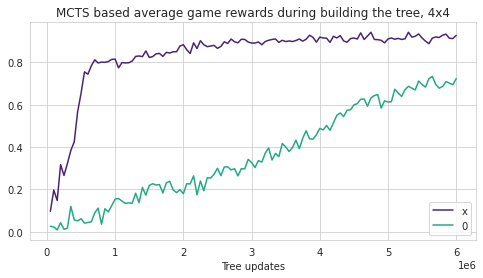

In [ ]:
fg, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot([eval_step * i for i in range(1, len(rewards_mcts[1]) + 1)], 
        rewards_mcts[1], 
        label="x",
        color=viridis(0.1))
ax.plot([eval_step * i for i in range(1, len(rewards_mcts[-1]) + 1)], 
        - np.array(rewards_mcts[-1]), 
        label="0",
        color=viridis(0.6))
ax.legend(loc="lower right")
ax.set_xlabel("Tree updates")
ax.set_title("MCTS based average game rewards during building the tree, 4x4")
fg.show()

The results of MCTS on 4x4 are comparable to the DQN, but are better for x and only slightly lower for 0s. The time aspect is less clear, since crosses took some time to train for DQN while it was quite fast for the MCTS. On the other hand training naughts for MCTS took a few hours, which is comparable to training the DQN. I would expect that the same result for naughts could have been achieved if I trained Q-learning for longer. 

In my understanding MCTS looks similar to the MC control with flat returns. Though different from Q-learning, I would expect the game stats to behave similarly for the two of them. And the way the naughts playing evolves with time looks similar.


